In [2]:
!pip install configargparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import sys

sys.path.append('../utils/')
import pandas as pd

import configargparse
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn import metrics

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval
from functools import partial
import pickle
import matplotlib.pyplot as plt

torch.set_printoptions(edgeitems=20, linewidth=200)

## Generate Data

In [4]:
def DataLorenz(stepcount, dt = 0.01, initx = 0., inity = 1., initz = 1.05, s = 10, r = 28, b = 8/3):
    x = np.zeros(stepcount+1)
    y = np.zeros(stepcount+1)
    z = np.zeros(stepcount+1)
    x[0], y[0], z[0] = (initx, inity, initz)
    for i in range(stepcount):
        x_dot = s*(y[i] - x[i])
        y_dot = r*x[i] - y[i] - x[i]*z[i]
        z_dot = x[i]*y[i] - b*z[i]
        x[i+1] = x[i] + (x_dot * dt)
        y[i+1] = y[i] + (y_dot * dt)
        z[i+1] = z[i] + (z_dot * dt)
    # Rescale to [-0.5, 0.5]
    x = (x - np.amax(x))/(np.amax(x)-np.amin(x)) + 0.5
    y = (y - np.amax(y))/(np.amax(y)-np.amin(y)) + 0.5
    z = (z - np.amax(z))/(np.amax(z)-np.amin(z)) + 0.5
    return x, y, z
    

In [5]:
datax, datay, dataz = DataLorenz(1499)

data_x = pd.DataFrame(datax, columns=['x'])
data_y = pd.DataFrame(datay, columns=['y'])
data_z = pd.DataFrame(dataz, columns=['z'])
data = pd.concat([data_x,data_y,data_z],axis = 1)

train_ = pd.DataFrame(data[0:700])
val_ = pd.DataFrame(data[700:1000])
train_val = pd.concat([train_,val_],axis = 0)
test_ = pd.DataFrame(data[1000:])

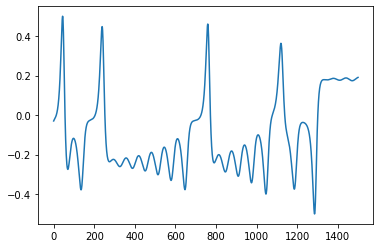

In [6]:
plt.plot(data_x)

## WaveNet

In [9]:
class DilatedCausalConv1d(nn.Module):
    def __init__(self, hyperparams: dict, dilation_factor: int, in_channels: int):
        super().__init__()
        
        def weights_init(m):
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight.data) #N～(0,std)，其中std=sqrt(2/(1+a^2)*fan_in)
                init.zeros_(m.bias.data)
        
        self.dilation_factor = dilation_factor
        self.dilated_causal_conv = nn.Conv1d(in_channels=in_channels, 
                            out_channels=hyperparams['nb_filters'], 
                            kernel_size=hyperparams['kernel_size'], 
                            dilation=dilation_factor)
        self.dilated_causal_conv.apply(weights_init)

        self.skip_connection = nn.Conv1d(in_channels=in_channels, 
                          out_channels=hyperparams['nb_filters'], 
                          kernel_size=1)
        self.skip_connection.apply(weights_init)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x): #Figure2.3 left
        x1 = self.leaky_relu(self.dilated_causal_conv(x)) #
        x2 = x[:, :, self.dilation_factor:]
        x2 = self.skip_connection(x2)
        return x1 + x2


In [10]:
class WaveNet(nn.Module):
    def __init__(self, hyperparams: dict, in_channels: int):
        super().__init__()
        
        def weights_init(m):
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight.data)
                init.zeros_(m.bias.data)
        
        self.dilation_factors = [2 ** i for i in range(0, hyperparams['nb_layers'])]
        self.in_channels = [in_channels] + [hyperparams['nb_filters'] for _ in range(hyperparams['nb_layers'])]
        self.dilated_causal_convs = nn.ModuleList(  #加入module和其parameters 
            [DilatedCausalConv1d(hyperparams, self.dilation_factors[i], self.in_channels[i]) for i in range(hyperparams['nb_layers'])])
        for dilated_causal_conv in self.dilated_causal_convs:
            dilated_causal_conv.apply(weights_init)

        self.output_layer = nn.Conv1d(in_channels=self.in_channels[-1], 
                        out_channels=1, 
                        kernel_size=1, groups=1)
        self.output_layer.apply(weights_init)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x): #Figure2.3 right
        for dilated_causal_conv in self.dilated_causal_convs:
            x = dilated_causal_conv(x)
        x = self.leaky_relu(self.output_layer(x))
        return x

##Deal With Dataset

In [11]:
class TrainDataset(Dataset):
    def __init__(self, train_df: pd.DataFrame, target_index: int, hyperparams: dict, horizon: int):

        train_df = train_df.values
        receptive_field = 2 ** (hyperparams['nb_layers'] - 1) * hyperparams['kernel_size'] #r=2**(L-1)*K
        padding = receptive_field - 1

        if hyperparams['conditional']:
            seq_x = train_df[:-horizon, :] 
            seq_y = train_df[horizon:, target_index].reshape(-1, 1)
        else:
            seq_x = train_df[:-horizon, target_index].reshape(-1, 1)
            seq_y = train_df[horizon:, target_index].reshape(-1, 1)

        # left-zero-pad inputs in the timesteps dimension
        seq_x = np.pad(seq_x, pad_width=((padding, 0), (0, 0)), mode='constant')

        seq_x = seq_x.T
        seq_y = seq_y.T

        self.seq_x = seq_x
        self.seq_y = seq_y

    def __len__(self):
        return self.seq_x.shape[1]

    def __getitem__(self, idx):
        return self.seq_x, self.seq_y

In [12]:
class EvalDataset(Dataset):
    def __init__(self, train_df: pd.DataFrame, oos_df: pd.DataFrame, target_index: int, hyperparams: dict, horizon: int):

        train_df = train_df.values
        oos_df = oos_df.values
        receptive_field = 2 ** (hyperparams['nb_layers'] - 1) * hyperparams['kernel_size']
        padding = receptive_field - 1

        if hyperparams['conditional']:
            seq_x = train_df[-horizon:, :]
            seq_y = oos_df[:horizon, target_index].reshape(-1, 1)
        else:
            seq_x = train_df[-horizon:, target_index].reshape(-1, 1)
            seq_y = oos_df[:horizon, target_index].reshape(-1, 1)

        # left-zero-pad inputs in the timesteps dimension
        seq_x = np.pad(seq_x, pad_width=((padding, 0), (0, 0)), mode='constant')

        seq_x = seq_x.T
        seq_y = seq_y.T

        self.seq_x = seq_x
        self.seq_y = seq_y

    def __len__(self):
        return self.seq_x.shape[1]

    def __getitem__(self, idx):
        return self.seq_x, self.seq_y


In [13]:
class PredDataset(Dataset):
    def __init__(self, input: pd.DataFrame, target_index: int, hyperparams: dict, horizon: int):

        input = input.values
        receptive_field = 2 ** (hyperparams['nb_layers'] - 1) * hyperparams['kernel_size'] #r=2**(L-1)*K
        padding = receptive_field - 1

        if hyperparams['conditional']:
            seq_x = input[-horizon:, :]
        else:
            seq_x = input[-horizon:, target_index].reshape(-1, 1)  # reshape to 2d e.g. (15300, 1)

        # left-zero-pad inputs in the timesteps dimension #在第一軸往前填充padding個數
        seq_x = np.pad(seq_x, pad_width=((padding, 0), (0, 0)), mode='constant') 

        seq_x = seq_x.T
        self.seq_x = seq_x

    def __len__(self):
        return self.seq_x.shape[1]

    def __getitem__(self, idx):
        return self.seq_x

## Wrapper

In [14]:
class WaveNetWrapper:

    def __init__(self, disable_cuda: bool):

        if disable_cuda:
            self.device = torch.device('cpu')
        elif torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            raise ValueError('System does not support CUDA.')
        self.net = None
        self.target_index = None
        self.train_val = None
        self.test = None
        self.losses = None
        self.horizon = None
        self.period = None
        self.mae_rmse_ignore_when_actual_and_pred_are_zero = None
        self.mape_ignore_when_actual_is_zero = None
        self.cross_validation_objective = None
        self.cross_validation_objective_less_is_better = None
        self.cross_validation_results = None
        self.best_hyperparams = None
        self.best_mean_train_metrics = None
        self.best_mean_val_metrics = None
        self.trials = None
        self.train_val_metrics = None
        self.mean_test_metrics = None
        self.max_evals = None
        self.runtime_in_minutes = None

    def predict(self, input: pd.DataFrame, target_index: int, hps: dict, horizon: int) -> np.array:
        # When predicting on val set, input = train
        # When predicting on test set, input = train_val or val
        dataset = PredDataset(input, target_index, hps, horizon)
        pred_loader = DataLoader(dataset, batch_size=1, num_workers=1)
        input = next(iter(pred_loader)) 
        input = input.to(device=self.device) #have both the model, and the data on the same device, either CPU or GPU
        self.net.eval() #Sets model in evaluation mode 
        #switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time
        self.net = self.net.to(device=self.device)
        pred = self.net(input.float())
        pred = pred.cpu().detach().numpy()
        pred = pred[0, 0, :] 
        pred = pred.round(5)
        return pred

    def train(self, train_df: pd.DataFrame, oos_df: pd.DataFrame, target_index: int, hyperparams: dict, horizon: int):

        tic = time.time()
        in_channels = train_df.shape[1] if hyperparams['conditional'] is True else 1 
        self.net = WaveNet(hyperparams, in_channels).to(device=self.device)
        self.net.train()
        self.losses = []

        train_dataset = TrainDataset(train_df=train_df, target_index=target_index, hyperparams=hyperparams, horizon=horizon)
        train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1)
        oos_dataset = EvalDataset(train_df=train_df, oos_df=oos_df, target_index=target_index, hyperparams=hyperparams, horizon=horizon)
        oos_loader = DataLoader(oos_dataset, batch_size=1, num_workers=1)

        # define the loss and optimizer
        loss_fn = nn.L1Loss()
        optimizer = optim.Adam(self.net.parameters(), lr=hyperparams['learning_rate'])

        # training loop:
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        oos_inputs, oos_labels = next(iter(oos_loader))
        oos_inputs, oos_labels = oos_inputs.to(self.device), oos_labels.to(self.device)

        best_oos_mae = None
        early_stopping = 0
        for epoch in range(hyperparams['max_epochs']):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.net(inputs.float()) #
            loss = loss_fn(outputs, labels.float())
            self.losses.append(loss)

            oos_outputs = self.net(oos_inputs.float())
            oos_outputs = torch.round(oos_outputs)
            oos_mae = nn.L1Loss()(oos_labels.float(), oos_outputs.float())

            if best_oos_mae is None:
                best_oos_mae = oos_mae
                torch.save(self.net.state_dict(), 'checkpoint.pt')
            elif oos_mae < best_oos_mae and epoch > 20: 
                best_oos_mae = oos_mae
                torch.save(self.net.state_dict(), 'checkpoint.pt')
                early_stopping = 0
            else:
                early_stopping += 1

            if early_stopping > hyperparams['early_stopping_rounds']:
                break

            reg_loss = np.sum([weights.norm(2).detach().numpy() for weights in self.net.parameters()])

            total_loss = loss + hyperparams['l2_reg'] / 2 * reg_loss
            total_loss.backward()
            optimizer.step()

            # print statistics
            outputs = torch.round(outputs)
            train_mae = nn.L1Loss()(labels.float(), outputs.float())

            #print('Epoch {} total loss: {} train mae: {} oos mae: {} best oos mae: {}'.format(epoch + 1,
            #    total_loss, train_mae, oos_mae, best_oos_mae))

        self.net = WaveNet(hyperparams, in_channels).to(device=self.device)
        self.net.load_state_dict(torch.load('checkpoint.pt'))
        self.net.eval()
        os.remove('checkpoint.pt')

        toc = time.time()
        #print('Training time: {} minutes'.format(str(round((toc - tic) / 60, 2))))

    @staticmethod
    def generate_origins(train: pd.DataFrame, oos: pd.DataFrame, horizon: int, period: int):

        if oos.shape[0] < horizon:
            raise ValueError(
                'Number of timestamps in oos: {} \nHorizon: {}\nNot enough timestamps in out-of-sample to do '
                'even one forecast'.format(
                    oos.shape[0], horizon))

        train_and_oos = pd.concat([train, oos])

        # find index of first origin
        origin = train.index.max()
        origin_idx = train_and_oos.index.tolist().index(origin)
        origins_as_idx = []

        # find index of all the origins
        while origin_idx < int(len(train_and_oos.index) - 1.5 * horizon):
            origins_as_idx.append(origin_idx)
            origin_idx += period
        origins_as_timestamps = [train_and_oos.index[origin_idx] for origin_idx in origins_as_idx]
        return origins_as_idx, origins_as_timestamps

    def calculate_train_and_forecast_metrics(self, train: pd.DataFrame, oos: pd.DataFrame, target_index: int, hps: dict, horizon: int):


        train_dataset = TrainDataset(train_df=train, target_index=target_index, hyperparams=hps, horizon=horizon)
        train_loader = DataLoader(train_dataset, batch_size=1, num_workers=1)
        inputs, train_actual = next(iter(train_loader))
        inputs = inputs.to(device=self.device)
        self.net = self.net.to(device=self.device)

        train_pred = self.net(inputs.float())
        train_actual = train_actual[0, 0, :].cpu().numpy()
        train_pred = train_pred[0, 0, :].cpu().detach().numpy()
        forecast_actual = oos.iloc[:horizon, target_index].values
        forecast_pred = self.predict(train, target_index, hps, horizon)

        assert (train_actual.shape == train_pred.shape)
        assert (forecast_actual.shape == forecast_pred.shape)

        train_dict = {'rmse': metrics.mean_squared_error(train_actual, train_pred, squared=False),
                'num_timestamps_predicted_on': int(train_pred.shape[0])}

        forecast_dict = {'rmse': metrics.mean_squared_error(forecast_actual, forecast_pred, squared=False),
                  'num_timestamps_predicted_on': int(forecast_pred.shape[0])}

        train_metrics = pd.DataFrame.from_dict(
            train_dict, columns=[None], orient='index').iloc[:, 0].round(3)

        forecast_metrics = pd.DataFrame.from_dict(
            forecast_dict, columns=[None], orient='index').iloc[:, 0].round(3)

        return train_metrics, forecast_metrics, forecast_pred

    def rolling_origin_eval(self, train: pd.DataFrame, oos: pd.DataFrame, target_index: int, horizon: int, period: int, hps: dict):

        origins_as_idx, origins_as_timestamps = self.generate_origins(train, oos, horizon, period)

        train_and_oos = pd.concat([train, oos])
        train_metrics_across_origins = []
        oos_metrics_across_origins = []
        for i, origin_idx in enumerate(origins_as_idx):
            #print('Origin: {} {}/{}'.format(origins_as_timestamps[i], i + 1, len(origins_as_idx)))
            train = train_and_oos[i * period:origin_idx + 1]
            oos = train_and_oos[origin_idx + 1: origin_idx + 1 + horizon]

            self.train(train_df=train, oos_df=oos, target_index=target_index, hyperparams=hps, horizon=horizon)
            train_metrics, oos_metrics, _ = self.calculate_train_and_forecast_metrics(train, oos, target_index, hps, horizon)

            train_metrics_across_origins.append(train_metrics)
            oos_metrics_across_origins.append(oos_metrics)

        # mean train and out-of-sample metrics across origins
        mean_train_metrics = np.mean(pd.concat(train_metrics_across_origins, axis=1), axis=1).round(3)
        mean_out_of_sample_metrics = np.mean(pd.concat(oos_metrics_across_origins, axis=1), axis=1).round(3)

        return mean_train_metrics, mean_out_of_sample_metrics

    def objective(self, params: dict, hyperparam_set: dict):
        print('{} | Training hyperparameter set {}'.format(params['train'].columns[params['target_index']],hyperparam_set))

        mean_train_metrics, mean_oos_metrics = self.rolling_origin_eval(train=params['train'], oos=params['val'], 
                                          target_index=params['target_index'], horizon=params['horizon'], 
                                          period=params['period'], hps=hyperparam_set )

        if params['cross_validation_objective_less_is_better']:
            try:
                return {'loss': mean_oos_metrics[params['cross_validation_objective']], 'status': STATUS_OK,
                        'hyperparam_set': hyperparam_set,
                        'mean_train_metrics': mean_train_metrics,
                        'mean_val_metrics': mean_oos_metrics}
            except Exception as e:
                return {'status': STATUS_FAIL, 'exception': str(e)}
        else:
            try:
                return {'loss': -1 * mean_oos_metrics[params['cross_validation_objective']], 'status': STATUS_OK,
                        'hyperparam_set': hyperparam_set,
                        'mean_train_metrics': mean_train_metrics,
                        'mean_val_metrics': mean_oos_metrics}
            except Exception as e:
                return {'status': STATUS_FAIL, 'exception': str(e)}

    def cross_validation(self, target_index: int, hyperparam_space: dict,
               train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame,
               horizon: int, period: int,
               cross_validation_objective: str, cross_validation_objective_less_is_better: bool, max_evals: int):
        """
        Tune hyperparameters using rolling origin evaluation. Retrain best model on time series containing training and
        validation data points. Evaluates metrics on test set. Saves model, meta data, and metrics.
        """
        #http://hyperopt.github.io/hyperopt/getting-started/minimizing_functions/
        tic = time.time()

        # rolling-origin evaluation to find the best hyperparam set
        #print('{} | Optimizing hyperparameters'.format(train.columns[target_index]))
        trials = Trials()
        params = {'target_index': target_index,
                  'train': train,
                  'val': val,
                  'horizon': horizon,
                  'period': period,
                  'cross_validation_objective_less_is_better': cross_validation_objective_less_is_better,
                  'cross_validation_objective': cross_validation_objective}
        best_hyperparams = fmin(fn=partial(self.objective, params),
                                space=hyperparam_space,
                                algo=tpe.suggest,
                                max_evals=max_evals,
                                trials=trials)
        best_hyperparams = space_eval(hyperparam_space, best_hyperparams)

        if cross_validation_objective_less_is_better:
            minimum = min([trial['mean_val_metrics'][cross_validation_objective] for trial in trials.results])
            idx = [trial['mean_val_metrics'][cross_validation_objective] for trial in trials.results].index(minimum)
        else:
            maximum = max([trial['mean_val_metrics'][cross_validation_objective] for trial in trials.results])
            idx = [trial['mean_val_metrics'][cross_validation_objective] for trial in trials.results].index(maximum)
        best_mean_train_metrics = [trial['mean_train_metrics'] for trial in trials.results][idx]
        best_mean_val_metrics = [trial['mean_val_metrics'] for trial in trials.results][idx]

        # rolling-origin evaluation to find test set performance using the best hyperparam set
        train_val = pd.concat([train, val])
        #print('{} | Rolling-origin evaluation on test'.format(train.columns[target_index]))
        _, mean_test_metrics = self.rolling_origin_eval(train=train_val, oos=test, target_index=target_index,
                                  horizon=horizon, period=period, hps=best_hyperparams)

        # train the final model on train_val
        print('{} | Training final model'.format(train.columns[target_index]))
        print(best_hyperparams)
        self.train(train_df=train_val, oos_df=test, target_index=target_index, hyperparams=best_hyperparams, horizon=horizon)
        train_val_metrics, _, forecast_pred = self.calculate_train_and_forecast_metrics(train_val, test, target_index, best_hyperparams, horizon)

        toc = time.time()
        runtime_in_minutes = round((toc - tic) / 60, 2)

        # save results
        self.target_index = target_index
        self.train_val = train_val
        self.test = test
        self.horizon = horizon
        self.period = period
        self.cross_validation_objective = cross_validation_objective
        self.cross_validation_objective_less_is_better = cross_validation_objective_less_is_better
        self.cross_validation_results = trials.results
        self.best_hyperparams = best_hyperparams
        self.best_mean_train_metrics = best_mean_train_metrics
        self.best_mean_val_metrics = best_mean_val_metrics
        self.trials = trials
        self.train_val_metrics = train_val_metrics
        self.forecast_pred = forecast_pred
        self.mean_test_metrics = mean_test_metrics
        self.max_evals = max_evals
        self.runtime_in_minutes = runtime_in_minutes
        print(runtime_in_minutes)

    def save(self, model_save_path):
        work_set_id_mapped = str(self.train_val.columns[self.target_index])
        print('Saving model for {} at {}'.format(work_set_id_mapped, model_save_path))
        if self.__module__ == '__main__':
            self.__module__ == WaveNetWrapper.__module__
        pickle.dump(self, open(model_save_path + work_set_id_mapped + '_model.p', 'wb+'))
        print('Save Complete')

## train cWaveNet_x & uWaveNet_x

In [22]:
target_index = 0
c_hyperparams = {'conditional':True, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
cWaveNet = WaveNetWrapper(disable_cuda = True)
cWaveNet.cross_validation(target_index = target_index, hyperparam_space=c_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

x | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.00178972472654602, 'max_epochs': 1000, 'nb_filters': 7, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.04538114706900866, 'max_epochs': 1000, 'nb_filters': 10, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0017470128639160412, 'max_epochs': 1000, 'nb_filters': 22, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.02326274593201773, 'max_epochs': 1000, 'nb_filters': 13, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.00773989173697364

In [23]:
cWaveNet.save('./cWaveNet0612_x')

Saving model for x at ./cWaveNet0612_x
Save Complete


In [24]:
cWaveNet.mean_test_metrics

rmse                             0.238
num_timestamps_predicted_on    200.000
dtype: float64

In [25]:
target_index = 0
u_hyperparams = {'conditional':False, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
uWaveNet = WaveNetWrapper(disable_cuda = True)
uWaveNet.cross_validation(target_index=target_index, hyperparam_space=u_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

x | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.00648158548780485, 'max_epochs': 1000, 'nb_filters': 14, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.004155625412812358, 'max_epochs': 1000, 'nb_filters': 17, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.003174676969109308, 'max_epochs': 1000, 'nb_filters': 10, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.002008186241283632, 'max_epochs': 1000, 'nb_filters': 12, 'nb_layers': 4}
x | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0016486450

In [26]:
uWaveNet.save('./uWaveNet0612_x')

Saving model for x at ./uWaveNet0612_x
Save Complete


In [27]:
uWaveNet.mean_test_metrics

rmse                             0.244
num_timestamps_predicted_on    200.000
dtype: float64

rmse                             0.313
num_timestamps_predicted_on    500.000
dtype: float64 rmse                             0.227
num_timestamps_predicted_on    500.000
dtype: float64


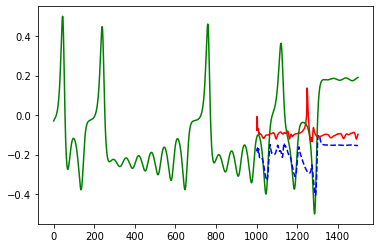

In [29]:
target_index = 0
iterations = 1000
c_predict = 0
u_predict = 0
c_rmse = 0
u_rmse = 0

for item in range(0,iterations):

  c_pre_result = cWaveNet.predict(train_val, target_index = target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_pre_result = uWaveNet.predict(train_val, target_index = target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_predict = c_predict + c_pre_result
  u_predict = u_predict + u_pre_result
  c_metrics_result = cWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_metrics_result = uWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_rmse = c_rmse + c_metrics_result[1]
  u_rmse = u_rmse + u_metrics_result[1]

x1 = np.arange(len(data_x))
x2 = np.arange(len(c_pre_result))+1000

c_predict = c_predict/iterations
u_predict = u_predict/iterations
plt.plot(x1,data_x,'g-')
plt.plot(x2,c_predict,'b--')
plt.plot(x2,u_predict,'r-')


c_rmse_result = c_rmse/iterations
u_rmse_result = u_rmse/iterations
print(c_rmse_result, u_rmse_result)

In [ ]:
with open('./x_model.p', 'rb') as f:
  abc = pickle.load(f)

##train cWaveNet_y & uWaveNet_y

In [ ]:
target_index = 1
c_hyperparams = {'conditional':True, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
cWaveNet = WaveNetWrapper(disable_cuda = True)
cWaveNet.cross_validation(target_index=target_index, hyperparam_space=c_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

y | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0055701578236190576, 'max_epochs': 1000, 'nb_filters': 22, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.008704097813308883, 'max_epochs': 1000, 'nb_filters': 19, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0011271219515308103, 'max_epochs': 1000, 'nb_filters': 12, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.031526608979298924, 'max_epochs': 1000, 'nb_filters': 15, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.002933438935

In [ ]:
cWaveNet.save('./cWaveNet0612_y')

Saving model for y at ./cWaveNet0612_y
Save Complete


In [ ]:
cWaveNet.mean_test_metrics

rmse                             0.206
num_timestamps_predicted_on    200.000
dtype: float64

In [ ]:
with open('./cWaveNet0611_yy_model.p', 'rb') as f:
  abc = pickle.load(f)

In [ ]:
abc.best_hyperparams

{'conditional': True,
 'early_stopping_rounds': 100,
 'kernel_size': 2,
 'l2_reg': 0.001,
 'learning_rate': 0.008860091411994014,
 'max_epochs': 1000,
 'nb_filters': 13,
 'nb_layers': 4}

In [ ]:
target_index = 1
u_hyperparams = {'conditional':False, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
uWaveNet = WaveNetWrapper(disable_cuda = True)
uWaveNet.cross_validation(target_index=target_index, hyperparam_space=u_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

y | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0047694709530668586, 'max_epochs': 1000, 'nb_filters': 15, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.004567356054258815, 'max_epochs': 1000, 'nb_filters': 12, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0054314635232938545, 'max_epochs': 1000, 'nb_filters': 15, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.03325750102505773, 'max_epochs': 1000, 'nb_filters': 21, 'nb_layers': 4}
y | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.02462773

In [ ]:
uWaveNet.save('./uWaveNet0612_y')

Saving model for y at ./uWaveNet0612_y
Save Complete


In [ ]:
uWaveNet.mean_test_metrics

rmse                             0.206
num_timestamps_predicted_on    200.000
dtype: float64

rmse                             0.287
num_timestamps_predicted_on    500.000
dtype: float64 rmse                             0.177
num_timestamps_predicted_on    500.000
dtype: float64


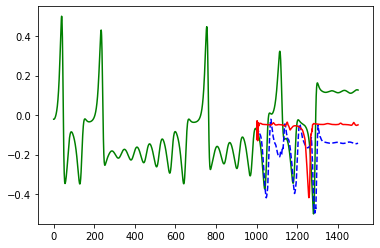

In [ ]:
target_index = 1
iterations = 1000
c_predict = 0
u_predict = 0
c_rmse = 0
u_rmse = 0

for item in range(0,iterations):

  c_pre_result = cWaveNet.predict(train_val, target_index = target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_pre_result = uWaveNet.predict(train_val, target_index = target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_predict = c_predict + c_pre_result
  u_predict = u_predict + u_pre_result
  c_metrics_result = cWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_metrics_result = uWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_rmse = c_rmse + c_metrics_result[1]
  u_rmse = u_rmse + u_metrics_result[1]

x1 = np.arange(len(data_y))
x2 = np.arange(len(c_pre_result))+1000

c_predict = c_predict/iterations
u_predict = u_predict/iterations
plt.plot(x1,data_y,'g-')
plt.plot(x2,c_predict,'b--')
plt.plot(x2,u_predict,'r-')



c_rmse_result = c_rmse/iterations
u_rmse_result = u_rmse/iterations
print(c_rmse_result, u_rmse_result)

## teain cWaveNet_z & uWaveNet_z

In [ ]:
target_index = 2
c_hyperparams = {'conditional':True, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
cWaveNet = WaveNetWrapper(disable_cuda = True)
cWaveNet.cross_validation(target_index=target_index, hyperparam_space=c_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

z | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0023619427133148084, 'max_epochs': 1000, 'nb_filters': 14, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0014359593116731342, 'max_epochs': 1000, 'nb_filters': 15, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.003571620062615661, 'max_epochs': 1000, 'nb_filters': 18, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0024265636059969597, 'max_epochs': 1000, 'nb_filters': 22, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': True, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.01998685579

In [ ]:
cWaveNet.save('./cWaveNet0612_z')

Saving model for z at ./cWaveNet0612_z
Save Complete


In [ ]:
cWaveNet.mean_test_metrics

rmse                             0.203
num_timestamps_predicted_on    200.000
dtype: float64

In [ ]:
target_index = 2
u_hyperparams = {'conditional':False, 'nb_layers':4, 'kernel_size':2,
        'nb_filters': hp.choice("nb_filters", np.arange(5, 25, 1, dtype=int)),
        'learning_rate': hp.loguniform("learning_rate", np.log(0.001), np.log(0.05)), 
        'l2_reg': 0.001, 'max_epochs':1000, 'early_stopping_rounds':100 }
uWaveNet = WaveNetWrapper(disable_cuda = True)
uWaveNet.cross_validation(target_index=target_index, hyperparam_space=u_hyperparams, train=train_, val = val_, test = test_, 
            horizon = 200, period = 1, 
            cross_validation_objective='rmse', 
            cross_validation_objective_less_is_better=True,
            max_evals=100)

z | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.010809416580896713, 'max_epochs': 1000, 'nb_filters': 7, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0012441616982630916, 'max_epochs': 1000, 'nb_filters': 24, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.0021315774483938784, 'max_epochs': 1000, 'nb_filters': 23, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.002125063785986265, 'max_epochs': 1000, 'nb_filters': 19, 'nb_layers': 4}
z | Training hyperparameter set {'conditional': False, 'early_stopping_rounds': 100, 'kernel_size': 2, 'l2_reg': 0.001, 'learning_rate': 0.01894213

In [ ]:
uWaveNet.save('./uWaveNet0612_z')

Saving model for z at ./uWaveNet0612_z
Save Complete


In [ ]:
uWaveNet.mean_test_metrics

rmse                             0.192
num_timestamps_predicted_on    200.000
dtype: float64

rmse                             0.168
num_timestamps_predicted_on    500.000
dtype: float64 rmse                             0.166
num_timestamps_predicted_on    500.000
dtype: float64


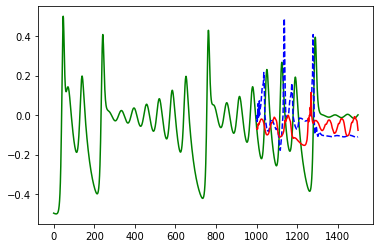

In [ ]:
target_index = 2
iterations = 1000
c_predict = 0
u_predict = 0
c_rmse = 0
u_rmse = 0

for item in range(0,iterations):

  c_pre_result = cWaveNet.predict(train_val, target_index = target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_pre_result = uWaveNet.predict(train_val, target_index = target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_predict = c_predict + c_pre_result
  u_predict = u_predict + u_pre_result
  c_metrics_result = cWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = cWaveNet.best_hyperparams, horizon = 500)
  u_metrics_result = uWaveNet.calculate_train_and_forecast_metrics(train = train_val, oos = test_, target_index=target_index, hps = uWaveNet.best_hyperparams, horizon = 500)
  c_rmse = c_rmse + c_metrics_result[1]
  u_rmse = u_rmse + u_metrics_result[1]

x1 = np.arange(len(data_z))
x2 = np.arange(len(c_pre_result))+1000

c_predict = c_predict/iterations
u_predict = u_predict/iterations
plt.plot(x1,data_z,'g-')
plt.plot(x2,c_predict,'b--')
plt.plot(x2,u_predict,'r-')



c_rmse_result = c_rmse/iterations
u_rmse_result = u_rmse/iterations
print(c_rmse_result, u_rmse_result)